# Modeling

The modeling modules in MTPy are designed to support third party software. I.e. they assist with input file generation and then analysis and visualisation of the results. Here, we give examples the three more commonly used software packages. Occam 1d, Occam 2d and ModEM.

## Occam 1D

This first example demonstrates how to create input files for inversion of MT data using the Occam 1D code (Key 2009, Constable et al 1987) - http://marineemlab.ucsd.edu/Projects/Occam/1DCSEM/.

There are three input files. 
* Data file, containing the data for inversion
* Model file (which contains the model mesh)
* Startup file - called by Occam1d and contains the data and model file names together with some control parameters for the inversion.

In [3]:
# import required modules
import os
import mtpy.modeling.occam1d as mtoc1d  

# full path to edi file and save path
edi_file = r'C:/mtpywin/mtpy/examples/data/edi_files_2/Synth00.edi'
savepath = r'C:/tmp/Occam1D_inv'

# make the save path if it doesn't exist
if not os.path.exists(savepath):
    os.mkdir(savepath)

# create data file
ocd = mtoc1d.Data()   #create an object and assign values to arguments
ocd.write_data_file(edi_file=edi_file,
                    mode='det',  # 'te', 'tm', or 'det'
                    save_path=savepath, # path to save to
                    res_errorfloor=4, # error floor in percentage
                    phase_errorfloor=2, # error floor in degrees
                    remove_outofquadrant=True)

# create model file
ocm = mtoc1d.Model(n_layers = 100, # number of layers
                   target_depth = 40000,# target depth in metres, 
                                        # before padding
                   bottom_layer = 100000, # total depth of model
                   z1_layer=10  # first layer thickness in metres
                   )
ocm.write_model_file(save_path=savepath)

# create startup file
ocs = mtoc1d.Startup(data_fn=ocd.data_fn,   # basename of data file
                     model_fn=ocm.model_fn,   # basename for model file
                     max_iter=200, # maximum number of iterations to run
                     target_rms=1.0
                    ) 
ocs.write_startup_file()

Wrote Data File to : C:/tmp\Occam1d_DataFile_DET.dat
Wrote Model file: C:/tmp\Model1D
Wrote Input File: C:/tmp\OccamStartup1D


### Viewing the outputs

Now that you have created the required inputs, you can run Occam1d on your files. Once you have done this, the following script can then be used to visualise the outputs as modelled and measured resistivity and phase, together with the 1D model. For this example below, we will use some example Occam 1D outputs from the mtpy examples directory. 

C:\mtpywin\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


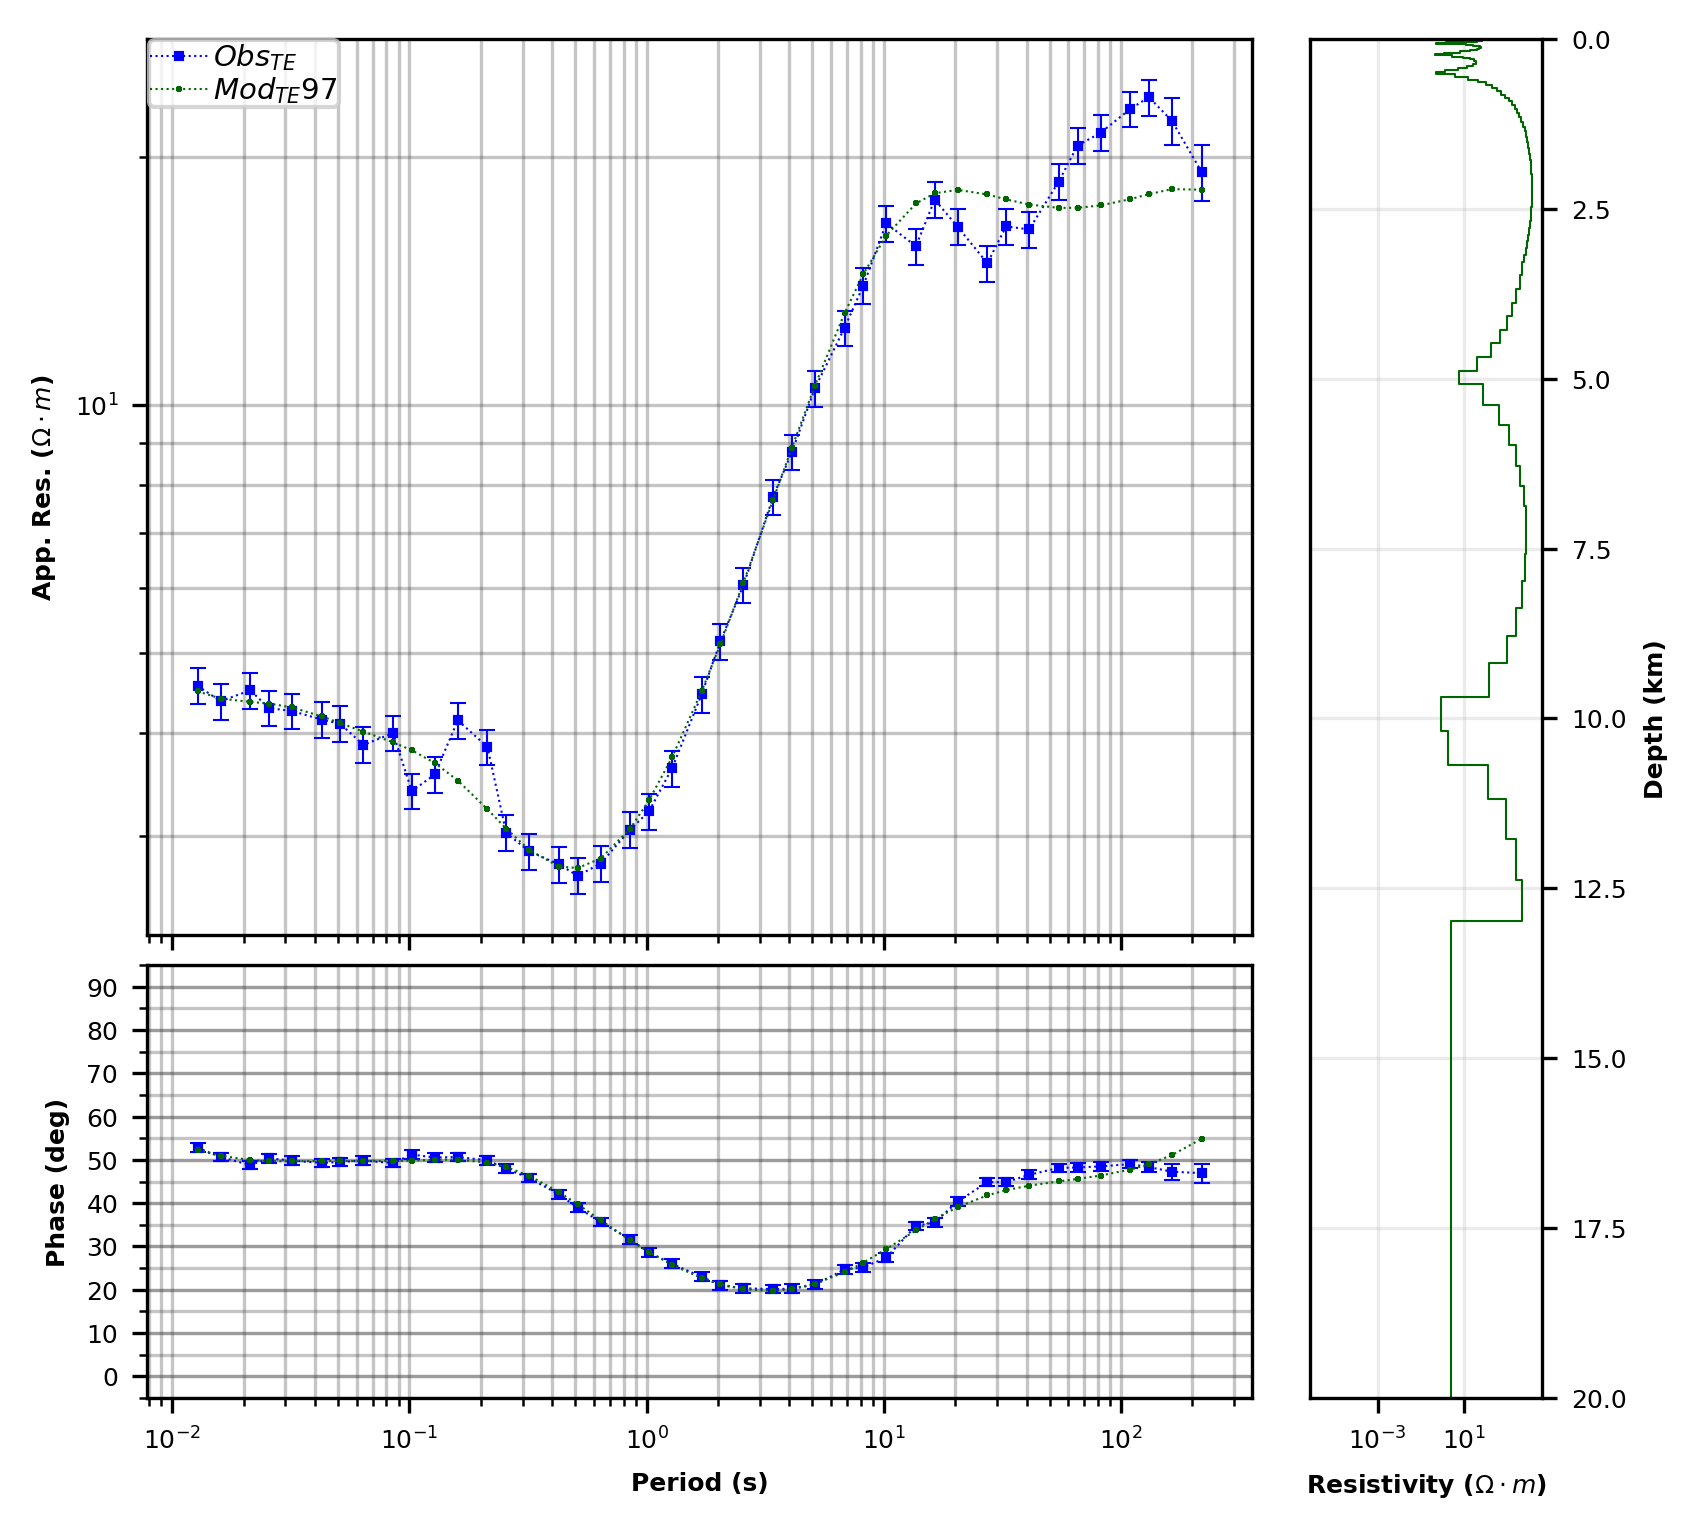

In [4]:
import mtpy.modeling.occam1d as mtoc1d
import os.path as op

# working directory
wd = r'C:\mtpywin\mtpy\examples\model_files\Occam1d'

# model and data file names
modelfn=op.join(wd,'Model1D')
datafn=op.join(wd,'Occam1d_DataFile_DET.dat')

iterfn  = op.join(wd,'ITER_97.iter')
respfn  = op.join(wd,'ITER_97.resp')

# read in the model, don't need these lines to view the model 
# but useful if you want to analyse the data
oc1m = mtoc1d.Model(model_fn=modelfn)
oc1m.read_iter_file(iterfn)

# read in the data file
oc1d = mtoc1d.Data(data_fn=datafn)
oc1d.read_data_file(data_fn=datafn)
oc1d.read_resp_file(resp_fn=respfn,data_fn=datafn)

# plot the model and response
pr = mtoc1d.Plot1DResponse(data_te_fn = datafn,
                           model_fn = modelfn,
                           resp_te_fn = respfn,
                           iter_te_fn = iterfn,
                           depth_limits = (0,20)
                           )

## Occam 2D

### Creating inputs

The example below shows how to set up input files for modelling using the Occam 2D software (Constable et al. 1987, deGroot-Hedlin and Constable, 1990, http://marineemlab.ucsd.edu/Projects/Occam/2DMT/index.html).

For more details on the specifics of the Occam 2D inversion code and input options, please refer to the Occam 2D user manual (Occam2DMT_FilesAndOptions.pdf) contained in the zip file from the above website. The input files required for modelling are described below.

There are four input files that are created.

* Data file - contains data for the inversions and relative station locations along the 2D profile used for the inversion

* Mesh file - contains mesh geometry information and information on which parameters are fixed/free

* Model file - details how mesh blocks are divided into model blocks (see Occam2D user manual)

* Startup file - contains control parameters for the inversion and the Data, Mesh, and Model file names

Rotated Z and Tipper to align with +0.10 degrees E of N
Profile angle is +90.10 degrees E of N


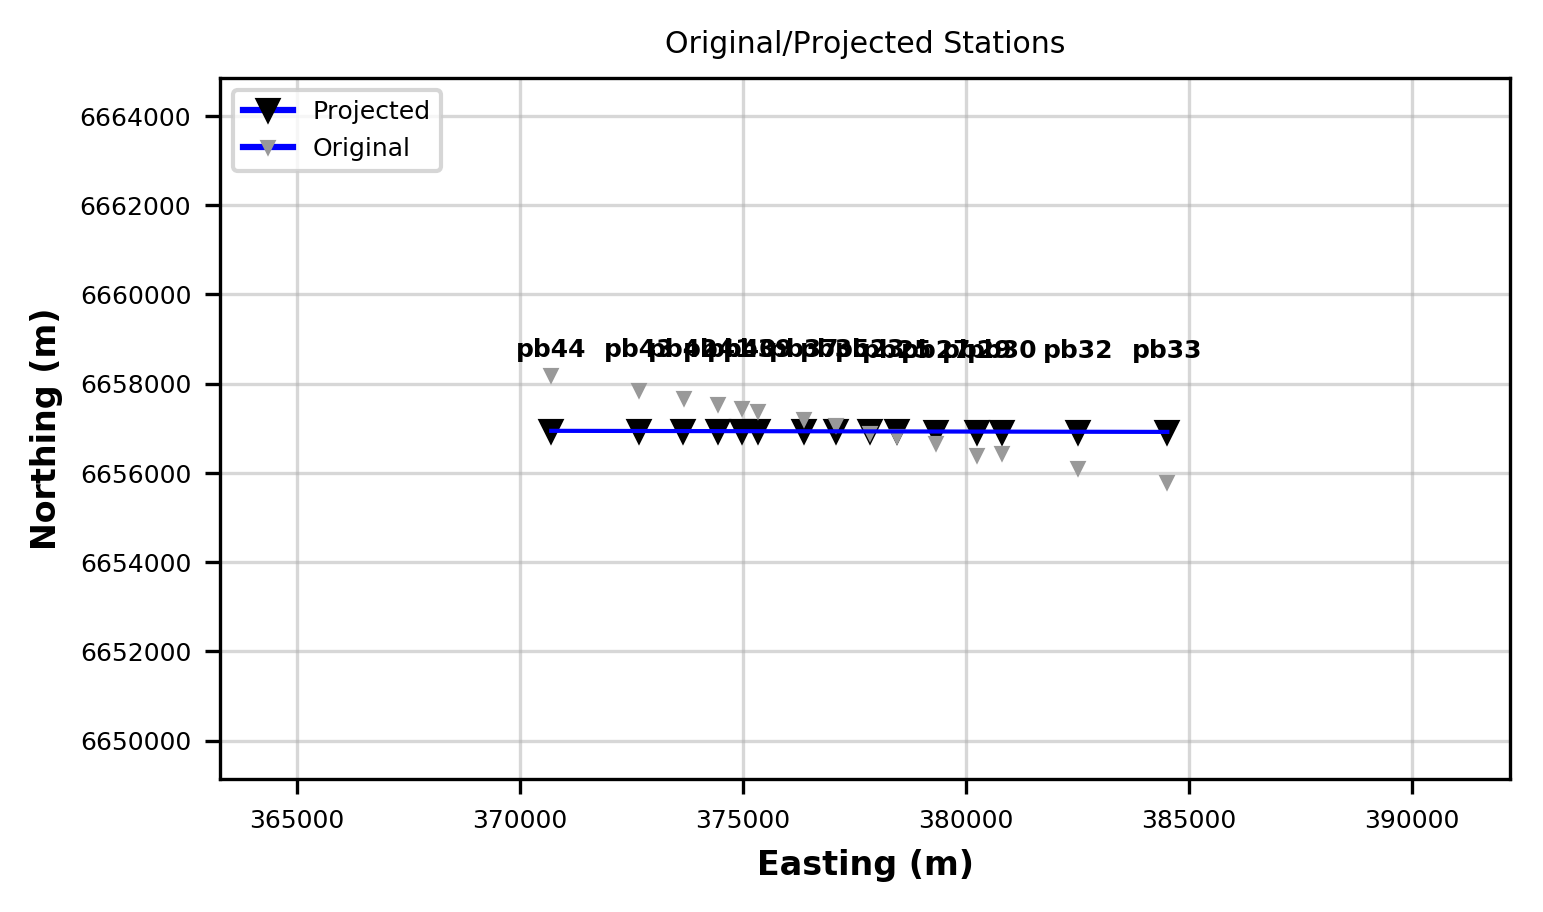

Wrote Occam2D data file to C:/tmp/Occam2D_inv\OccamDataFile.dat
                    MESH PARAMETERS                    
  number of horizontal nodes = 160
  number of vertical nodes   = 90
  Total Horizontal Distance  = 28594.665131
  Total Vertical Distance    = 293170.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 85
   number of parameters = 4267
   number of free param = 4267
                    MESH PARAMETERS                    
  number of horizontal nodes = 33
  number of vertical nodes   = 60
  Total Horizontal Distance  = 904894.259656
  Total Vertical Distance    = 358330.000000
               REGULARIZATION PARAMETERS               
   binding offset       = 0.0
   number layers        = 55
   number of parameters = 498
   number of free param = 498
Wrote Mesh file to C:/tmp/Occam2D_inv\Occam2DMesh
Wrote Regularization file to C:/tmp/Occam2D_inv\Occam2DModel
Wrote Occam2D startup file to C:/tmp/Occam2D_

In [7]:
import mtpy.modeling.occam2d_rewrite as occam2d
import os
import numpy as np


# path where edi files are located
edipath = r"C:/mtpywin/mtpy/examples/data/edi_files"

# path to save to
savepath = r'C:/tmp/Occam2D_inv'

# make the save path if it doesn't exist
if not os.path.exists(savepath):
    os.mkdir(savepath)

# list of stations
slst=[edi[0:-4] for edi in os.listdir(edipath) if edi.find('.edi')>0]

# create an occam data object
ocd = occam2d.Data(edi_path=edipath,
                   station_list=slst,
                   interpolate_freq=True, # interpolate frequencies
                   freq=np.logspace(-3,3,37) # frequency list to invert for
                   )
ocd.save_path = savepath

#### make data file
# geoelectric strike for rotation
# if not specified will calculate from the data
ocd.geoelectric_strike = 0.1

# error floors
ocd.res_te_err = 10 # error floor 
ocd.res_tm_err = 10
ocd.phase_te_err = 5
ocd.phase_tm_err = 5
ocd.model_mode = '1' # modes to invert for - see 
# https://mtpy2.readthedocs.io/en/develop/modeling.html#module-occam-2d
# for options
ocd.write_data_file()

# make model and mesh files
ocr = occam2d.Regularization(ocd.station_locations)
ocr.n_layers = 60 # number of layers
ocr.cell_width = 1250 # cell width to aim for, note this is the 
                      # mesh size (2 mesh blocks across per model block)
ocr.x_pad_multiplier = 1.9 # controls size of padding
ocr.trigger= 0.25 # controls aspect ratio of blocks
ocr.z_bottom = 200000 # bottom of model
ocr.z1_layer = 50 # z1 layer and target depth in metres
ocr.z_target_depth = 80000 # target depth for inversion
ocr.save_path=ocd.save_path
ocr.build_mesh()
ocr.build_regularization()
ocr.write_mesh_file()
ocr.write_regularization_file()
#ocr.plot_mesh() # uncomment to plot the mesh

# make startup file
ocs=occam2d.Startup()
ocs.iterations_to_run=100
ocs.resistivity_start=2.0 # log10(starting resistivity)
ocs.target_misfit = 1.2
ocs.data_fn=op.join(ocd.data_fn)
ocr.get_num_free_params()
ocs.param_count=ocr.num_free_param
ocs.save_path=ocd.save_path
ocs.model_fn=ocr.reg_fn
ocs.write_startup_file()

Now that you have created the required inputs, you can run Occam2d on your files. Once you have done this, the following script can then be used to visualise the outputs as modelled and measured resistivity and phase, together with the 2D model. For this example below, we use some example Occam 2D outputs from the mtpy examples directory. 

### Viewing the model

Reading from C:/mtpywin/mtpy/examples/model_files/Occam2d\OccamDataFile.dat
    profile_angle = 97.0
    geoelectric_strike = 7.0
    number of sites = 15
    number of frequencies = 19


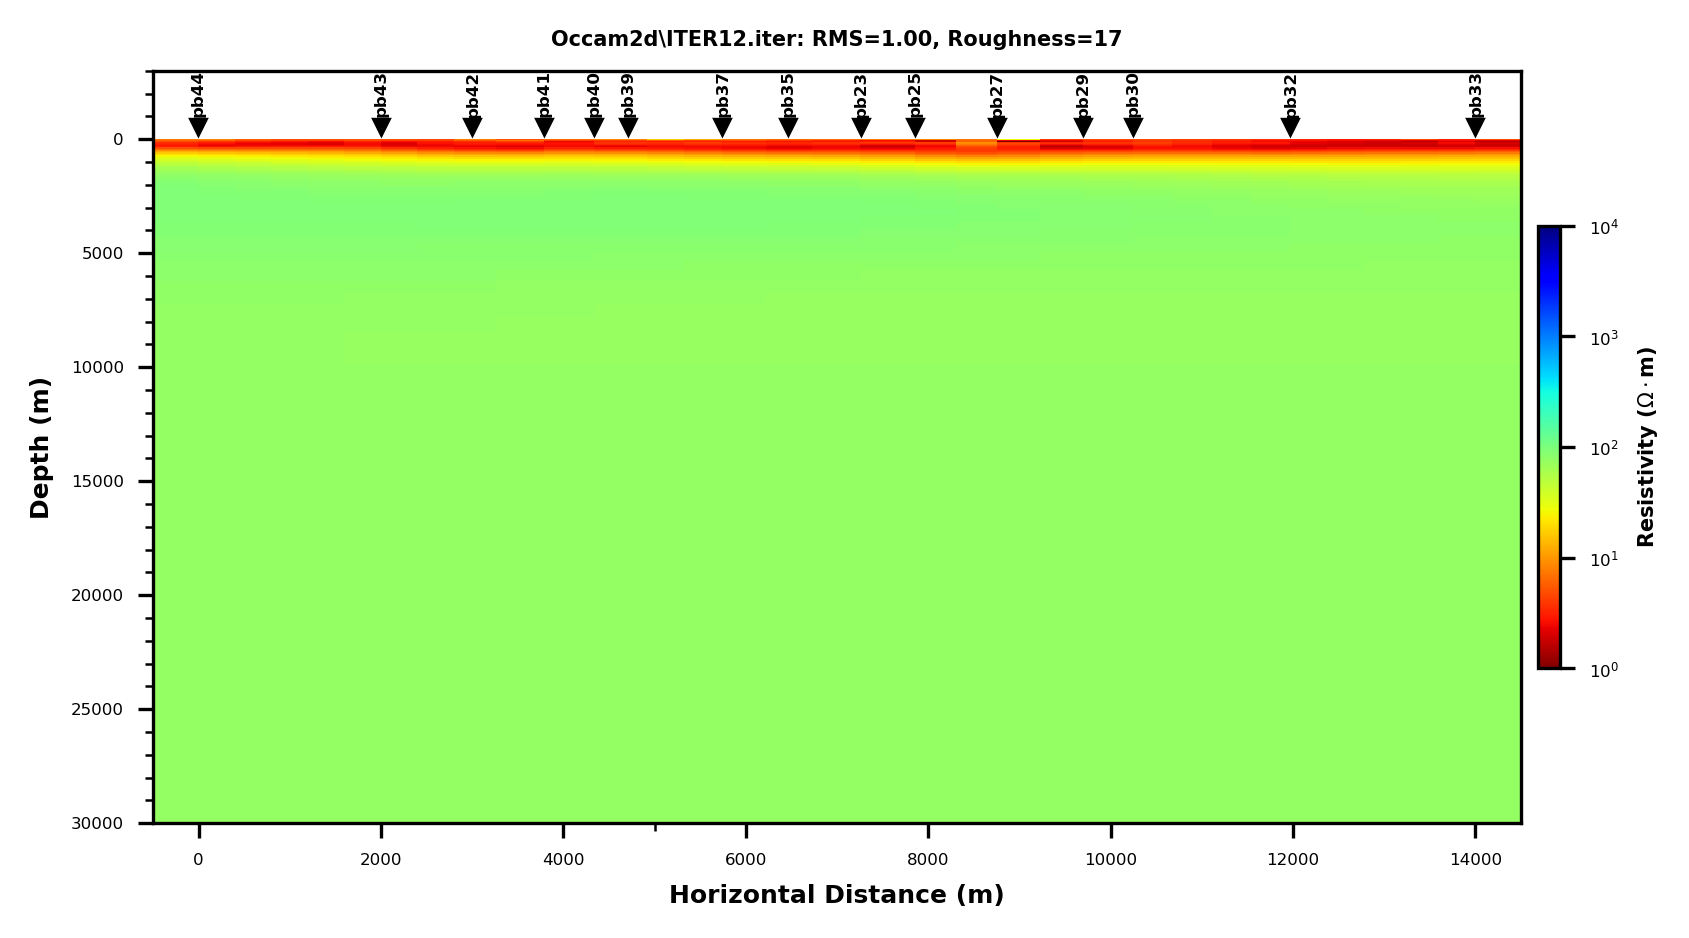

Saved figure to: C:/tmp\model.png


<Figure size 432x288 with 0 Axes>

In [18]:
# Import required modules
from mtpy.modeling.occam2d_rewrite import PlotModel
import os

# path to directory containing inversion files
idir = r'C:/mtpywin/mtpy/examples/model_files/Occam2d'
savepath = r'C:/tmp'

# iteration and response files
iterfile = 'ITER12.iter'
datafn = 'OccamDataFile.dat'

# define file paths
pltm = PlotModel(iter_fn=os.path.join(idir,iterfile),
            data_fn=os.path.join(idir,datafn),
            station_font_pad = 2.5, # pad (in plot units) between station
                                    # symbol and station label
            station_font_size = 4, # station font size
            station_font_rotation = 90, # rotation of the station font
            font_size=4, # font size to use
            climits=(0,4), # colour scale limits
            cb_shrink= 0.3, # controls the size of the colorbar
            xpad=0.5, # pad (in km) either side of profile
            yscale = 'm', # 'm' or 'km'
            yminorticks = 1., 
            dpi=300, # resolution of figure
            fig_aspect = 0.25,   # aspect ratio between horizontal 
                                 # and vertical scale
            ylimits = (-2,30), # depth limits
            stationid=(-1,3)) # index of station name to plot

# save the model
pltm.save_figure(os.path.join(savepath,'model.png'))


### Viewing the responses

Below is a simple example of plotting a response from a single station from an Occam 2D inversion. See the documentation pages for the Occam 2d mtpy modules for more details.

Reading from C:/mtpywin/mtpy/examples/model_files/Occam2d\OccamDataFile.dat
    profile_angle = 97.0
    geoelectric_strike = 7.0
    number of sites = 15
    number of frequencies = 19


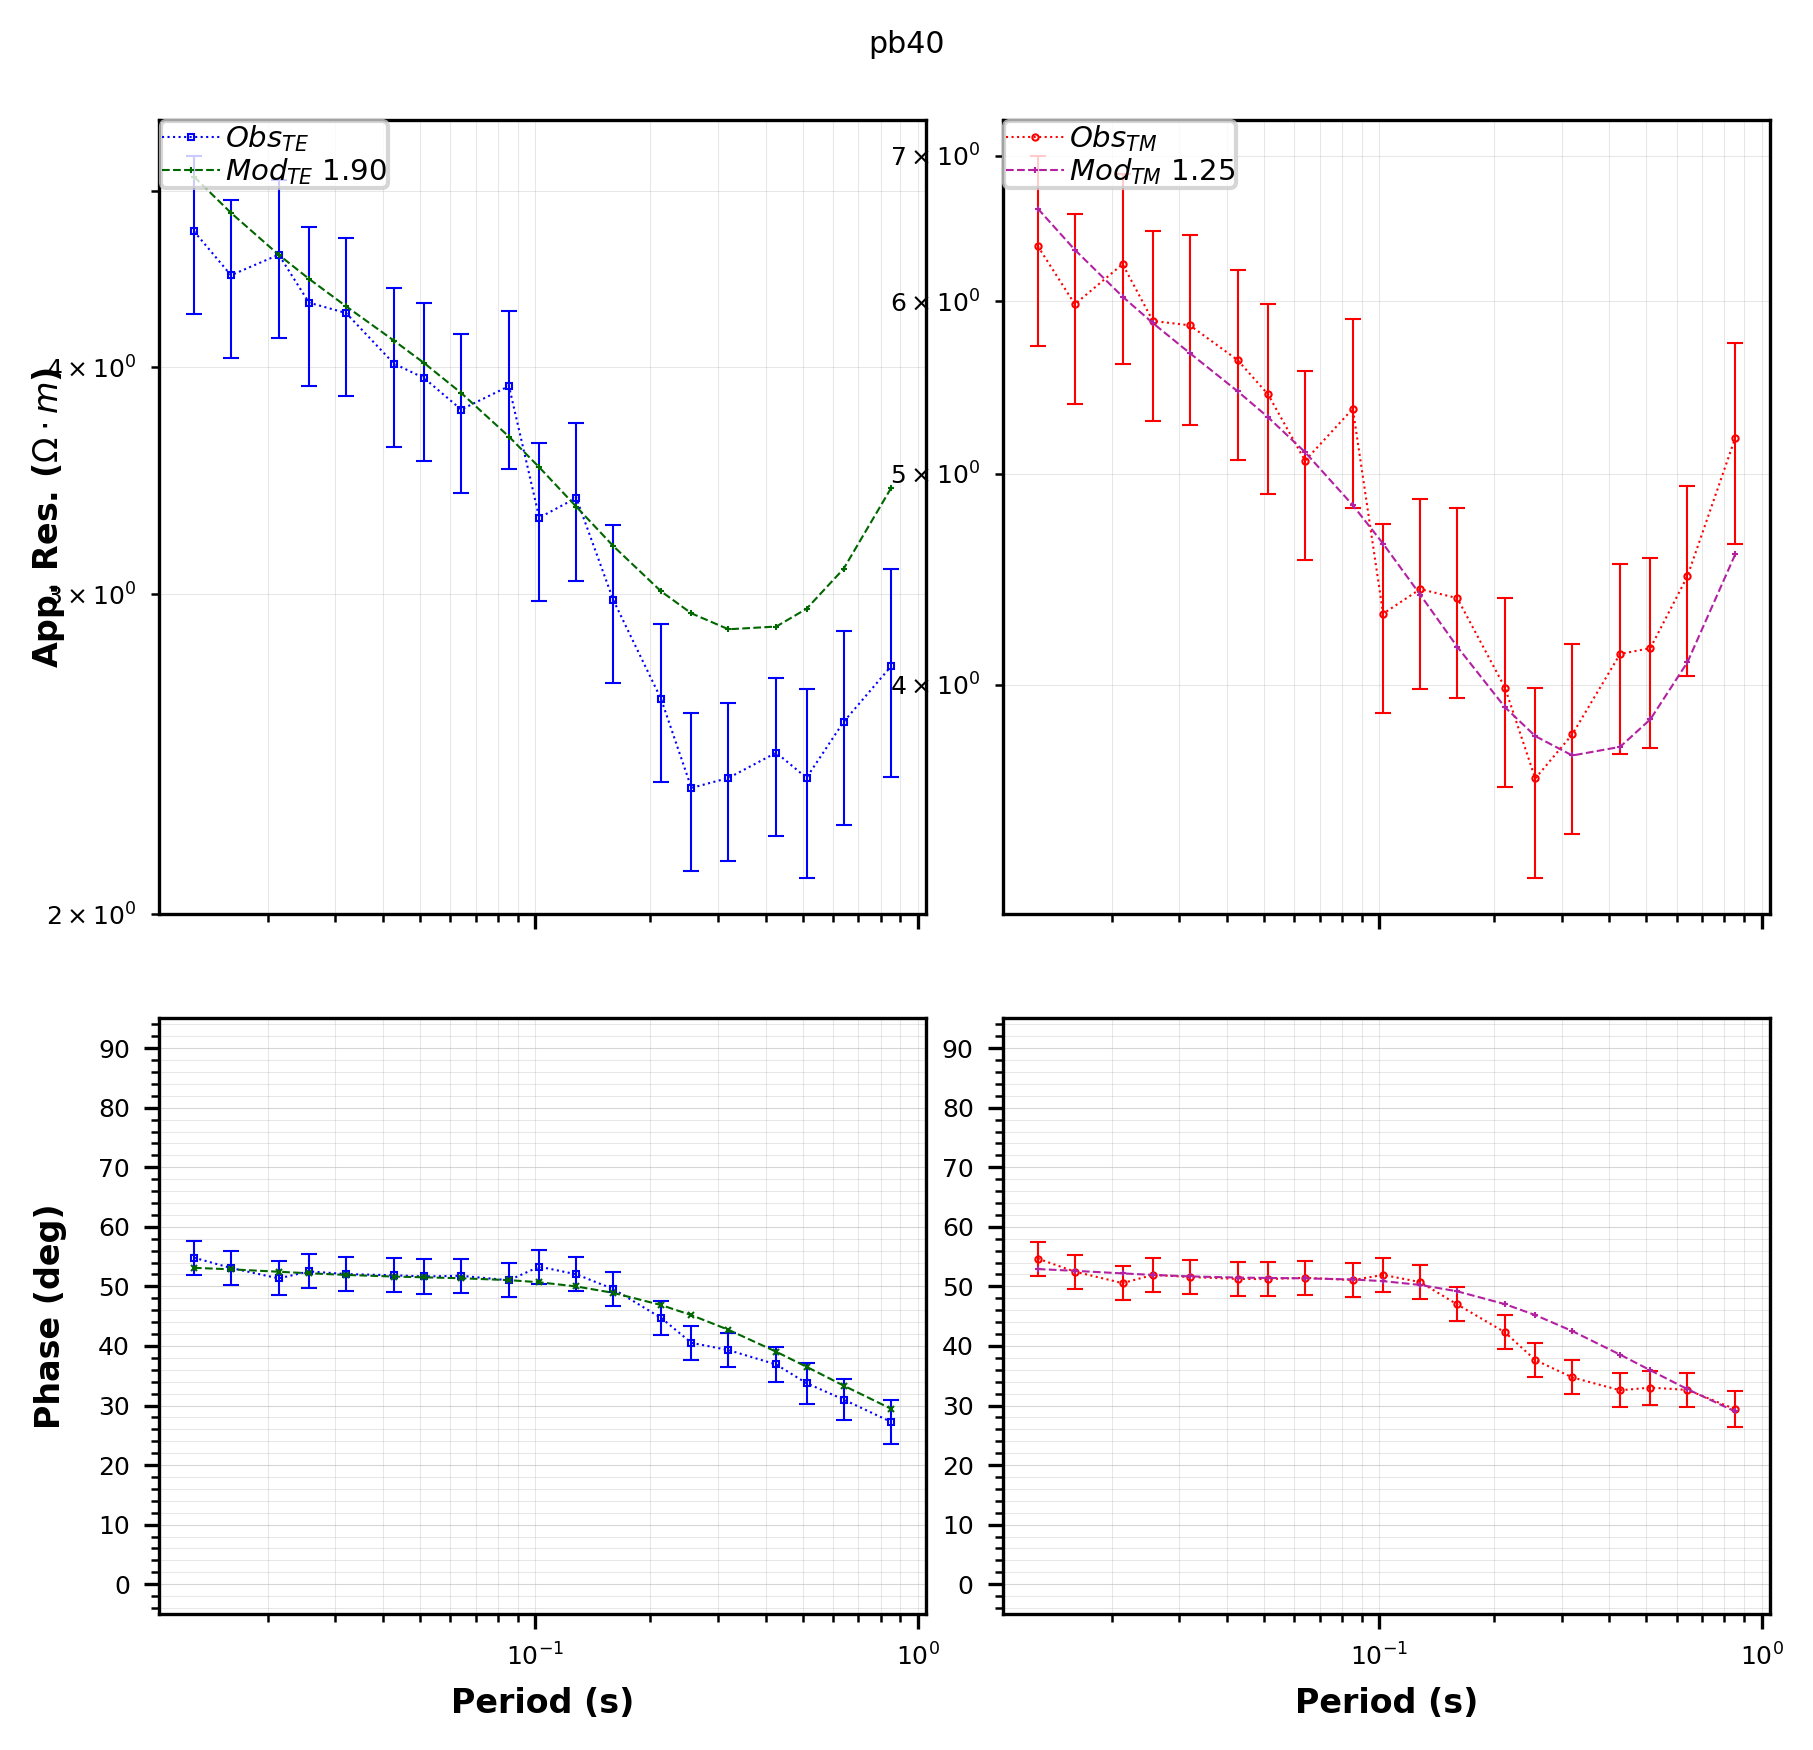

saved figure to C:/tmp\Occam2dresponses\pb40_resp.png


In [27]:
# Import required modules
from mtpy.modeling.occam2d_rewrite import PlotResponse
import os

# path to directory containing inversion files
idir = r'C:/mtpywin/mtpy/examples/model_files/Occam2d'

# data and response files
datafn = 'OccamDataFile.dat'
respfile = 'RESP12.resp'

# plot response
pr = PlotResponse(os.path.join(idir,datafn),
                 resp_fn = os.path.join(idir,respfile),
                 plot_type=['pb40'] # either a list of stations to plot
                                    # or '1' to plot all stations
                 )
pr.save_figures(os.path.join(savepath,'Occam2dresponses'),
               fig_fmt='png')

## ModEM

### Creating Inputs

The example below demonstrates how to set up input files for 3D inversion using the ModEM inversion code (Egbert and Kelbert 2012; Kelbert et al. 2014; http://blogs.oregonstate.edu/modem3dmt/).

The ModEM code has three compulsory input files:

* Model file - contains information on the mesh size and starting resistivity

* Data file - contains the impedance tensor and tipper data at each frequency and station locations

* Covariance file - contains model covariance parameters, which control smoothing

#### Data file

The data file needs to be created before any of the other files can be made. This is because the data file reads the station locations, and these are then used to create a grid centred on the stations. There are a number of different parameters you can vary - see the comments next to each line when creating the data object. You need to check these are correct - MTPy assumes you know what you are doing and will not give you an error if you choose the wrong projection, for example.

In [2]:
import os
from mtpy.modeling.modem import Data
from mtpy.core.edi import Edi
from mtpy.utils.calculator import get_period_list
import numpy as np

# path to save to
workdir = r'C:/tmp/ModEM_inv'

# make the save path if it doesn't exist
if not os.path.exists(workdir):
    os.mkdir(workdir)

# path containing edi files
edipath = r'C:/mtpywin/mtpy/examples/data/edi_files_2'

# find all files in edipath
edi_list = [os.path.join(edipath,ff) for ff in os.listdir(edipath) if \
            (ff.endswith('.edi'))]

# define period list to interpolate data onto
# MTPy will not extrapolate outside the data period range
# this code gets 4 periods per decade
period_list = get_period_list(1e-4,3e3,4)

# create a data object
do = Data(edi_list=edi_list,
          inv_mode = '1', # invert for Z + tipper ('2' means Z only)
          save_path=workdir,
          period_list=period_list,
          period_buffer=2., # buffer factor to determine how far to interpolate 
                            # between points. 2 means interpolate by a factor of 
                            # 2. e.g. if the data is at 10s the code will 
                            # interpolate only from 5 to 20 s.
          error_type_z='floor_egbert', # error type (egbert is % of sqrt(zxy*zyx))
          error_value_z=5., # error floor in percent
          error_type_tipper = 'floor_abs', # type of error to set in tipper, 
          
                                           # floor_abs is an absolute value set 
                                           # as a floor
          error_value_tipper=0.01,
          model_epsg=28354 # model epsg, currently set to utm zone 54. 
                                # See http://spatialreference.org/ to 
                                # find the epsg code for your projection
               )
# write data file, setting elevation to zero as we haven't added topography
do.write_data_file()

# save epsg code and centre position to a text file
np.savetxt(os.path.join(workdir,'center_position.txt'),
           np.array([do.center_point['east'], 
                     do.center_point['north']]))
np.savetxt(os.path.join(workdir,'epsg.txt'),[do.model_epsg])


If you want to write a vtk file for 3d viewing, you need download and install evtk from https://bitbucket.org/pauloh/pyevtk
Note: if you are using Windows you should build evtk first witheither MinGW or cygwin using the command: 
    python setup.py build -compiler=mingw32  or 
    python setup.py build -compiler=cygwin
If you want to write a vtk file for 3d viewing, you need to install pyevtk
Note: if you are using Windows you should build evtk first witheither MinGW or cygwin using the command: 
    python setup.py build -compiler=mingw32  or 
    python setup.py build -compiler=cygwin
If you want to write a vtk file for 3d viewing, you need download and install evtk from https://bitbucket.org/pauloh/pyevtk


If you want to write a vtk file for 3d viewing, you need download and install evtk from https://bitbucket.org/pauloh/pyevtk


If you want to write a vtk file for 3d viewing, you need to pip install PyEVTK: https://bitbucket.org/pauloh/pyevtk
Note: if you are using Windows you should build evtk first witheither MinGW or cygwin using the command: 
    python setup.py build -compiler=mingw32  or 
    python setup.py build -compiler=cygwin
--------------------------------------------------
Inverting for periods:
     0.000100    
     0.000178    
     0.000316    
     0.000562    
     0.001000    
     0.001778    
     0.003162    
     0.005623    
     0.010000    
     0.017783    
     0.031623    
     0.056234    
     0.100000    
     0.177828    
     0.316228    
     0.562341    
     1.000000    
     1.778279    
     3.162278    
     5.623413    
     10.000000   
     17.782794   
     31.622777   
     56.234133   
     100.000000  
     177.827941  
     316.227766  
     562.341325  
     1000.000000 
     1778.279410 
     3162.277660 
--------------------------------------------------


C:\mtpywin\mtpy\mtpy\utils\calculator.py:308: RuntimeWarning: invalid value encountered in double_scalars
  z_rel_err = error/z_amp


2018-09-21T13:56:31 - Data - INFO - Wrote ModEM data file to C:/tmp\ModEM_Data.dat


#### Model file

Once the data file has been created, we now create the model file. MTPy creates a grid that covers the stations with the provided cell size. You can update parameters like cell size, target depth, padding parameters, and first layer thickness as described below.

Once the model is created, we then add topography. In the example below we will use etopo1 topography/bathymetry data downloaded from https://www.ngdc.noaa.gov/mgg/global/.

After topography is added to the model, we then need to change the station elevations so that the stations sit on the topography.

In [3]:
from mtpy.modeling.modem import Model

# create a Model object
mo = Model(station_locations=do.station_locations,
                cell_size_east=8000,
                cell_size_north=8000,
                pad_north=7, # number of padding cells N and S
                pad_east=7,# number of padding cells E and W
                pad_z=6, # number of vertical padding cells
                pad_num=6, # number of cells outside station area before padding
                pad_stretch_v=1.6, # increase factor in padding cells (vertical)
                pad_stretch_h=1.9, # increase factor in padding cells (horizontal)
                n_air_layers = 10, # number of air layers
                res_initial_value=100, # halfspace resistivity value 
                                       # for reference model (ohm-m)
                n_layers=100, # total number of z layers, including air
                z1_layer=50, # first layer thickness
                pad_method='stretch', # method for calculating padding
                z_target_depth=300000 # approx. depth to bottom of core model 
                                      # (padding after this depth)
                )

mo.make_mesh()
mo.write_model_file(save_path=workdir)

## add topography to the model and rewrite
topo_file = r'C:/mtpywin/mtpy/examples/data/AussieContinent_etopo1.asc'
mo.add_topography_to_model2(topo_file)
mo.write_model_file(save_path=workdir)

# project the stations on the topography
do.project_stations_on_topography(mo)

---------------
	Number of stations = 28
	Dimensions: 
		e-w = 87
		n-s = 73
		z  = 101 (without 7 air layers)
	Extensions: 
		e-w = 2147600.0 (m)
		n-s = 2035600.0 (m)
		0-z = 1188110.0 (m)
	Stations rotated by: 0.0 deg clockwise positive from N

 ** Note ModEM does not accommodate mesh rotations, it assumes
    all coordinates are aligned to geographic N, E
    therefore rotating the stations will have a similar effect
    as rotating the mesh.
---------------
 Elevation data type and shape  ***  <type 'numpy.ndarray'> (72L, 86L) 72 72
--------------------------------------------------
Inverting for periods:
     0.000100    
     0.000178    
     0.000316    
     0.000562    
     0.001000    
     0.001778    
     0.003162    
     0.005623    
     0.010000    
     0.017783    
     0.031623    
     0.056234    
     0.100000    
     0.177828    
     0.316228    
     0.562341    
     1.000000    
     1.778279    
     3.162278    
     5.623413    
     10.000000   
    

([16,
  18,
  20,
  22,
  24,
  26,
  28,
  30,
  32,
  34,
  36,
  38,
  40,
  42,
  44,
  46,
  48,
  50,
  52,
  54,
  55,
  57,
  59,
  61,
  63,
  65,
  67,
  69],
 [55,
  53,
  52,
  50,
  49,
  47,
  46,
  44,
  43,
  41,
  40,
  38,
  37,
  35,
  34,
  32,
  31,
  29,
  28,
  26,
  25,
  23,
  22,
  20,
  19,
  17,
  16,
  14])

The final step is to create a covariance file, which provides information on the location of free vs fixed parameters, and smoothing. The covariance file is created based on the model file we generated in the previous step.

In [4]:
from mtpy.modeling.modem import Covariance

# create a covariance file
co = Covariance()
co.smoothing_east = 0.6
co.smoothing_north = 0.6
co.smoothing_z = 0.6
co.write_covariance_file(model_fn=mo.model_fn)

    -1017800.000    -1073800.000        -473.000

    0.000

Reading C:/tmp\ModEM_Model_File.rho


### Viewing outputs

Once you've run ModEM there are quite a few functions available to look at model outputs. Alternatively, you can use MTPy to write the model to a Gocad sgrid format and use Gocad to interrogate the model.

#### Resistivity model slice

The first function we demonstrate is how to plot a ModEM depth slice. Note that this function has an option for interactive plotting if you run it as a script and set plot_yn to 'y'. Here we will just use static plotting.

     -386800.000     -442800.000           0.000

    0.000

2018-09-19T12:13:27 - Data - INFO - Set rotation angle to 0.0 deg clockwise from N
=============== ===============================================
    Buttons                  Description                       
=============== ===============================================
     'e'          moves n-s slice east by one model block
     'w'          moves n-s slice west by one model block
     'n'          moves e-w slice north by one model block
     'm'          moves e-w slice south by one model block
     'd'          moves depth slice down by one model block
     'u'          moves depth slice up by one model block
=============== ===============================================
Exporting C:/tmp\N-E-plane-at-Depth032.1.616.km.png..


([<Figure size 2400x1200 with 2 Axes>],
 ['C:/tmp\\N-E-plane-at-Depth032.1.616.km.png'])

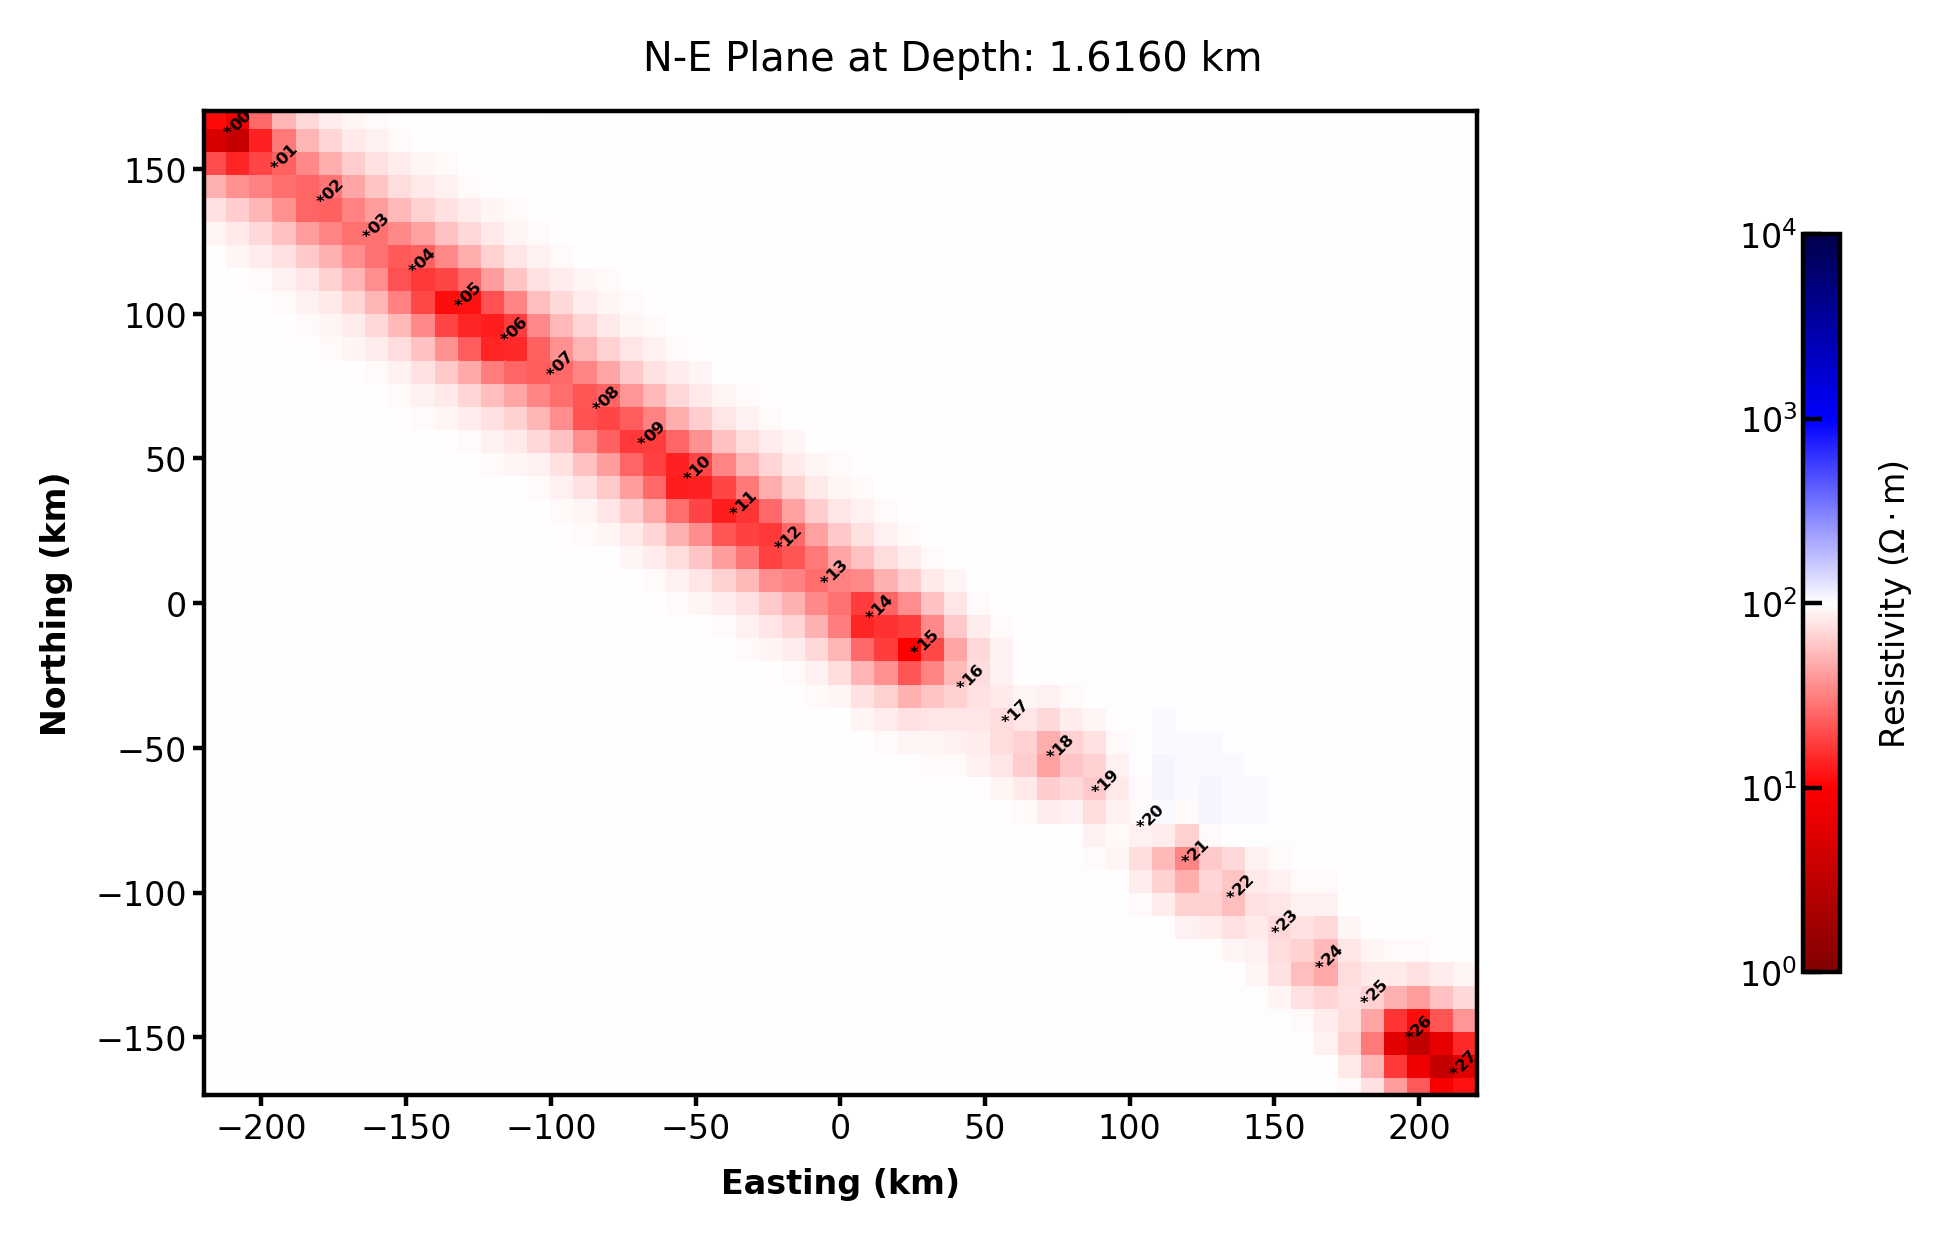

In [34]:
import os
from mtpy.modeling.modem import PlotSlices

wd = r'C:/mtpywin/mtpy/examples/model_files/ModEM_2'

savepath = r'C:/tmp'

model_fn = os.path.join(wd,'Modular_MPI_NLCG_004.rho')
data_fn = os.path.join(wd,'ModEM_Data.dat')

pObj = PlotSlices(model_fn=model_fn,
        data_fn=data_fn,
        save_path=wd,
        cmap='seismic_r', # colour map
        plot_stations=True, # True/False - show station locations or not
        station_id=[5,8], # indices (start,finish) of station label to plot
        ew_limits=[-220,220], # east-west limits, if not provided 
                              # will auto calculate from data
        ns_limits=[-170,170], # north-south limits, if not provided 
                              # will auto calculate from data
        font_size=6, # font size on plots
        fig_size=(6,3), # figure size
        plot_yn='n', # whether to load interactive plotting
        fig_dpi = 400 # change to your preferred file resolution
                  )

pObj.save_path = savepath
pObj.export_slices(plane='N-E', # options are 'N-Z', 'E-Z', and 'N-E'
                   indexlist=[32], # slice index to plot
                   station_buffer=20e3, # distance threshold for plotting
                                        # stations on vertical slice
                   save=True,
                   )

#### Plot model along arbitrary profile

The example below shows how to plot stations along an arbitrary profile, which is particularly useful in the case where you may have run a 3D model on 2D profile data. Please see the code below for parameters that can be varied.

      -15500.000      -21500.000         -67.000

    0.000

2018-09-19T12:13:35 - Data - INFO - Set rotation angle to 0.0 deg clockwise from N
=============== ===============================================
    Buttons                  Description                       
=============== ===============================================
     'e'          moves n-s slice east by one model block
     'w'          moves n-s slice west by one model block
     'n'          moves e-w slice north by one model block
     'm'          moves e-w slice south by one model block
     'd'          moves depth slice down by one model block
     'u'          moves depth slice up by one model block
=============== ===============================================


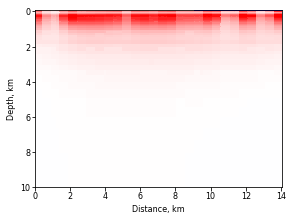

In [35]:
import os

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

from mtpy.modeling.modem import PlotSlices

# working directory and save path
wd = r'C:/mtpywin/mtpy/examples/model_files/ModEM'
savepath = r'C:/tmp'

# model and data file names
model_fn = os.path.join(wd,'Modular_MPI_NLCG_004.rho')
data_fn = os.path.join(wd,'ModEM_Data.dat')
fs = 8 # fontsize on plot

# create a PlotSlices object
ps = PlotSlices(model_fn=model_fn, 
                data_fn=data_fn,
                save_path=wd,
                plot_yn='n')

# create a new figure
fig = plt.figure(figsize=[6,3])
ax = plt.subplot(111)

# get resistivity data along a slice defined by the stations
gd, gz, gv = ps.get_slice("STA", 
                          nsteps=1000 # total number of cells across
                         )

ci = ax.pcolormesh(gd, gz, gv,
              vmin=1,vmax=1e4, # min & max resistivity on colour map
              norm=colors.LogNorm(), # plot colours on a log scale
               cmap='bwr_r', # colour map
               rasterized=True)

# set some plot parameters and add labels
ax.invert_yaxis()
ax.set_aspect(1)
ax.set_ylim(10)
plt.setp(ax.get_xticklabels(),fontsize=fs)
plt.setp(ax.get_yticklabels(),fontsize=fs)
plt.xlabel('Distance, km',fontsize=fs)
plt.ylabel('Depth, km',fontsize=fs)

plt.savefig(os.path.join(savepath,'DepthSlice.png'),
            dpi=400) # change to your desired figure resolution

#### Data and model response

The example below shows how to plot the data together with the model response at one or more stations.

2018-09-19T12:13:42 - Data - INFO - Set rotation angle to 0.0 deg clockwise from N
2018-09-19T12:13:42 - Data - INFO - Set rotation angle to 0.0 deg clockwise from N
Plotting: Synth02
self.plot_tipper = True


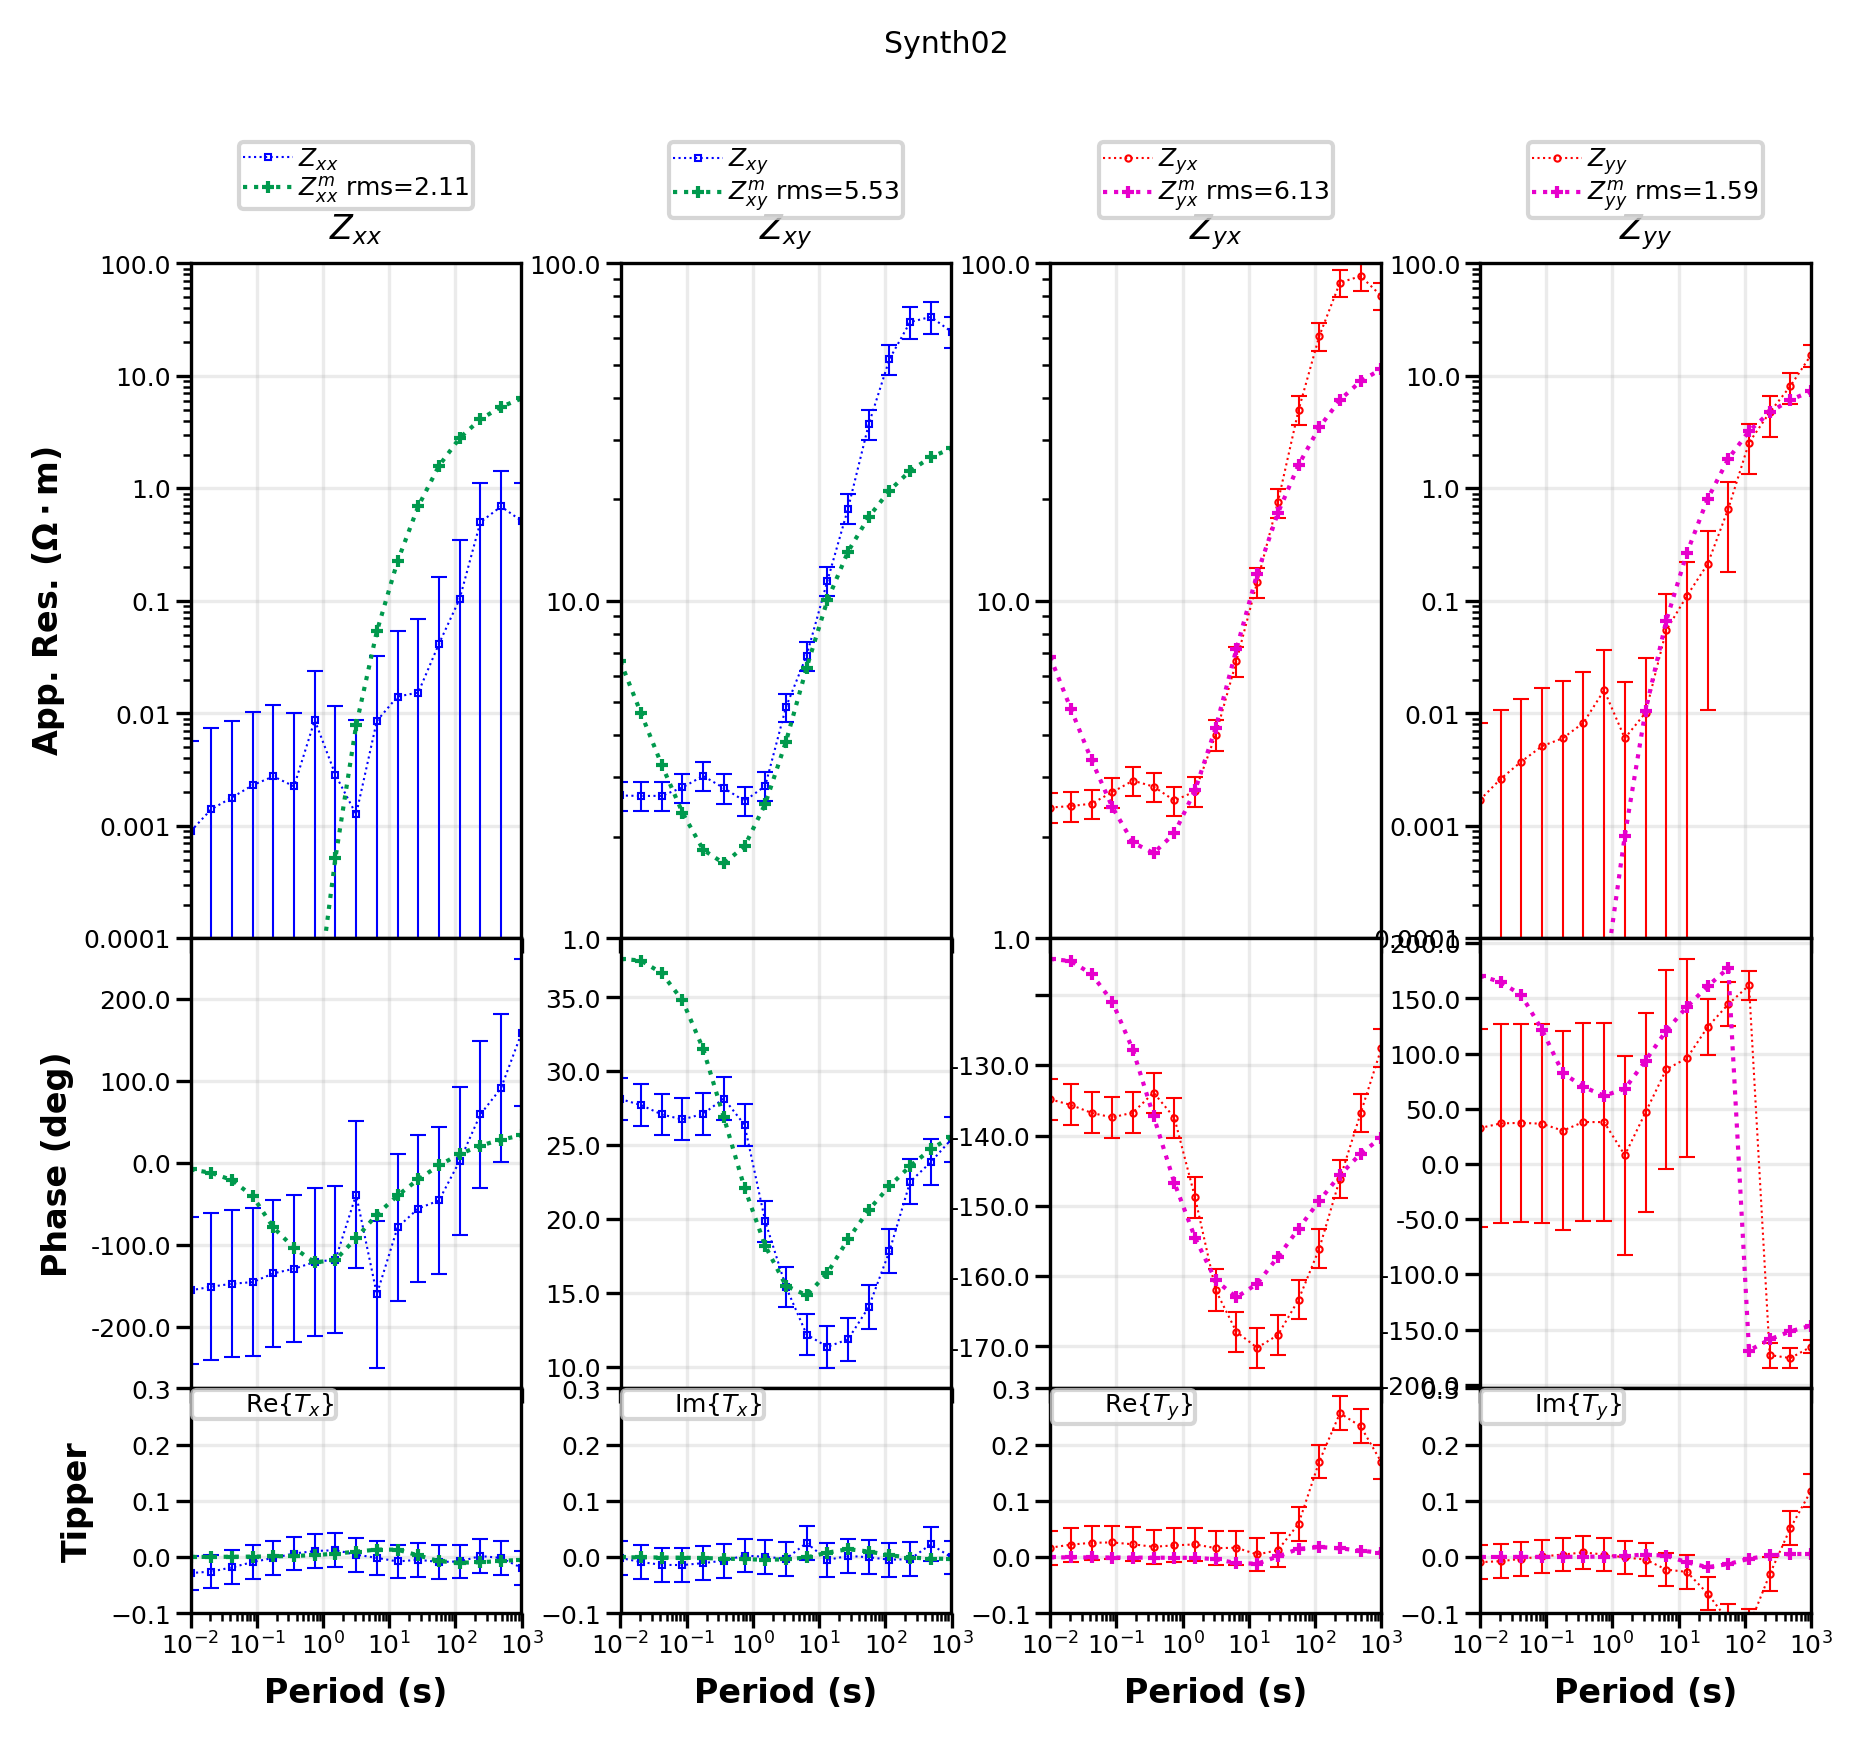

Saved figure to: C:/tmp\response.png


In [36]:
import os
from mtpy.modeling.modem import PlotResponse

# working directory and save path
wd = r'C:/mtpywin/mtpy/examples/model_files/ModEM_2'
savepath = r'C:/tmp'

# response and data files
respfn = 'Modular_MPI_NLCG_004.dat'
datafn = 'ModEM_Data.dat'

# make a plot object
ro = PlotResponse(data_fn=os.path.join(wd,datafn),
                  resp_fn=os.path.join(wd,respfn),
                  plot_type=['Synth02'], # provide a list of station names
                                         # or '1' to plot all stations
                  plot_style=1,  # 1 for 4-colums; 2 for 2-columns
                  plot_z=False,
                  )
ro.plot()

ro.save_figure(os.path.join(savepath,'response.png'),
               fig_dpi=400) # change fig_dpi to your desired resolution


#### Phase tensor plots

This example shows how to plot model and response phase tensors for a specified frequency, as a map. Depending on what inputs you provide, you can plot the data, model response, and the residual phase tensor, which is a measure of the difference between the data and model response. 

('The input parameter period is', 10)
2018-09-19T12:13:47 - Data - INFO - Set rotation angle to 0.0 deg clockwise from N
2018-09-19T12:13:47 - Data - INFO - Set rotation angle to 0.0 deg clockwise from N
Plotting Period: 13.335
{'edgecolor': 'k', 'lw': 0.5}


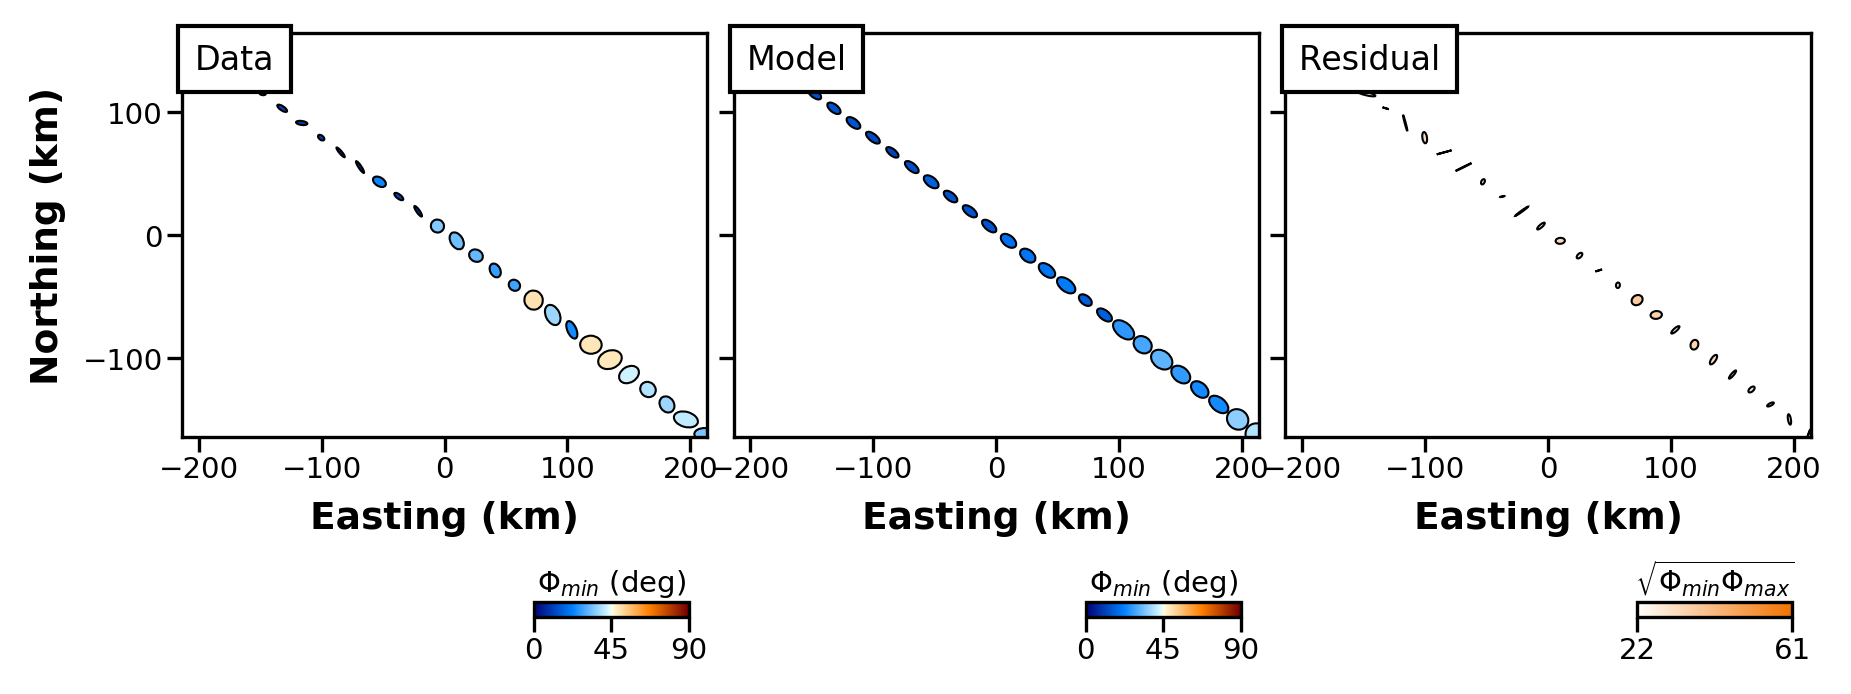

Saved figure to: C:/tmp\PT_DepthSlice_images.png


In [37]:
import os
from mtpy.modeling.modem.phase_tensor_maps import PlotPTMaps


workdir = r'C:/mtpywin/mtpy/examples/model_files/ModEM_2'
savepath= r'C:/tmp'

ptmap = PlotPTMaps(data_fn=os.path.join(workdir, 'ModEM_Data.dat'),
            resp_fn=os.path.join(workdir, 'Modular_MPI_NLCG_004.dat'),
            cb_pt_pad=0.0, # y position of colorbar on plot
            fig_size=(6,2.5),
            ellipse_dict =  {'size': 20,
                             'ellipse_range':[0, 90],
                             'ellipse_colorby':'phimin',
                             'ellipse_cmap':'mt_bl2gr2rd'},
            residual_cmap='mt_wh2or'
            )

for period_index in [10]: # customise which periods to plot
    ptmap.plot(period=period_index, # index of period to plot
               edgecolor='k', # colour for edge of ellipses
               lw = 0.5 # linewidth of edge of ellipses
               )

# save all plots to file
ptmap.save_figure(save_path=savepath,
                  file_format='png',
                  fig_dpi=400) # change to your desired resolution

#### RMS maps

These functions plot the (normalised) data-model misfit. You can choose an integer value for period_index to plot a particular period, or just specify 'all' to plot the root-mean-square misfit over all periods. The plots are broken up according to component - $Z_{XX}$, $Z_{XY}$, $Z_{YX}$, $Z_{YY}$, $T_{X}$, $T_{Y}$.

2018-09-19T12:13:51 - Data - INFO - Set rotation angle to 0.0 deg clockwise from N


C:\mtpywin\mtpy\mtpy\modeling\modem\residual.py:197: RuntimeWarning: invalid value encountered in divide
  z_norm = np.abs(res_vals['z']) / (np.real(res_vals['z_err']) * 2. ** 0.5)
C:\mtpywin\mtpy\mtpy\modeling\modem\residual.py:211: RuntimeWarning: invalid value encountered in divide
  tip_norm = np.abs(res_vals['tip']) / (np.real(res_vals['tip_err']) * 2. ** 0.5)
C:\mtpywin\Anaconda2\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


saved file to C:/tmp\RMS_AllPeriods.png


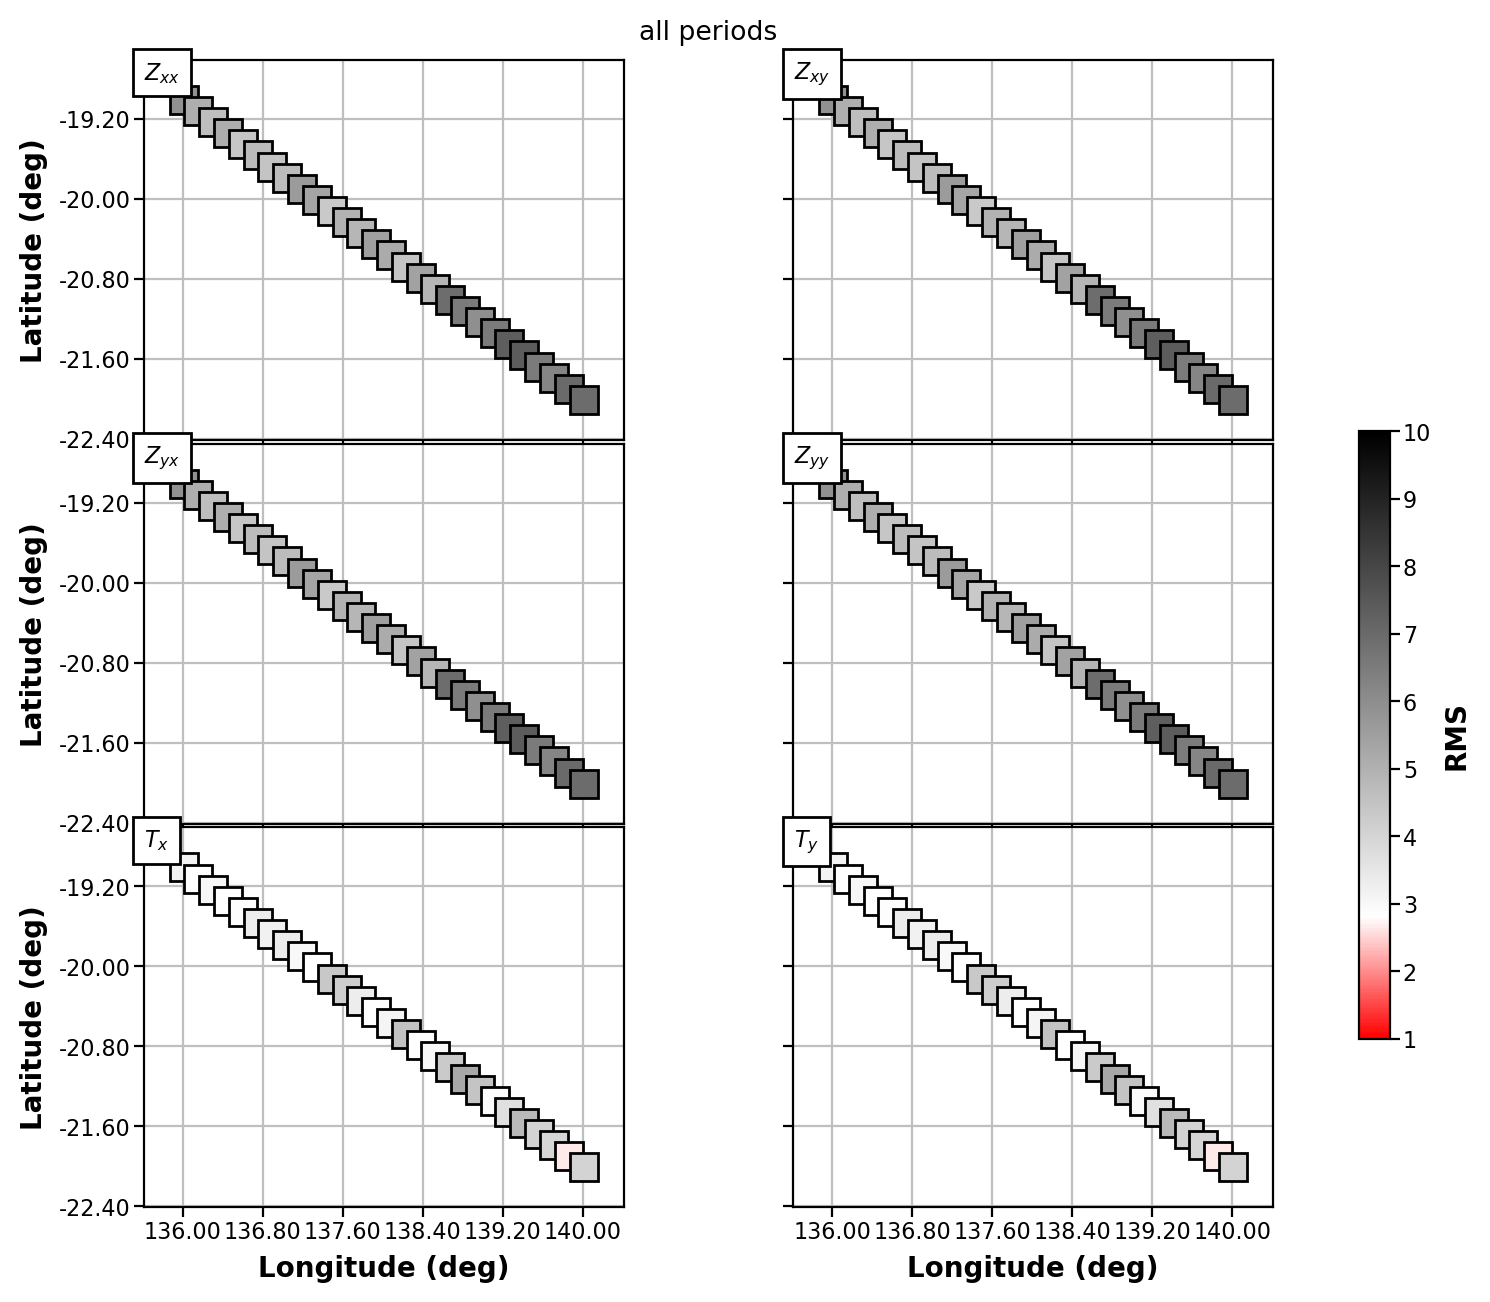

In [38]:
import os
import numpy as np
from mtpy.modeling.modem import PlotRMSMaps

wd = r'C:/mtpywin/mtpy/examples/model_files/ModEM_2'
savepath = r'C:/tmp'

resid_fn = os.path.join(wd,'Modular_MPI_NLCG_004.res')

# create a RMS plot object
probj = PlotRMSMaps(resid_fn,
                    rms_min=1, # min rms for colorbar
                    rms_max=10, # max rms for colorbar
                    period_index='all' # 'all' or integer value
                   )

# save figure
probj.save_figure(save_path=savepath,
                  fig_close=False, # whether or not to close figure
                  save_fig_dpi = 400 # change to your preferred figure resolution
                  )